In [259]:
import os
import scipy.signal as sp
%matplotlib inline
import sys  
import importlib

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp
import gauss_splat_2 as gp2

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal

## Load Calibration Data

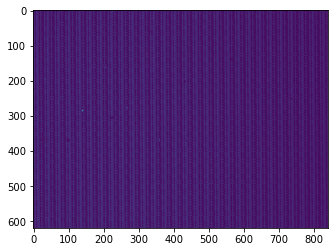

Shape of the filter array: torch.Size([620, 840, 45])


In [260]:
# Filter mask

# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
filt_arr = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)
filt_arr = filt_arr / np.amax(filt_arr) # normalize
m = torch.tensor(filt_arr) # make tensor

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(m, axis=2))
plt.show()

# Print the shape of the tensor
print("Shape of the filter array:", m.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = m.shape

torch.Size([620, 840])


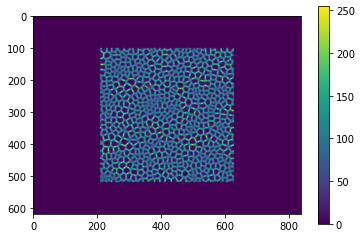

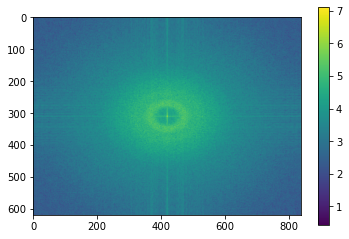

In [261]:
# PSF

datafolder = '../Calibration_Data'
fname = 'psf_090_1.png'
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

 # Expand the PSF to match the shape of the filter array
pad_h = (m.shape[0] - psf.shape[0]) // 2
pad_w = (m.shape[1] - psf.shape[1]) // 2
padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

hf = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(hf)))
plt.colorbar()
plt.show()

# Create measurement

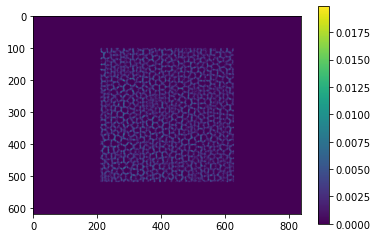

In [262]:
# Create and pad X -- point source
obj = torch.zeros_like(m)
loc = [0,0] # y,x offset from center
obj[int(NY/2+loc[0]),int(NX/2+loc[1]),:] = 1.0
obj_padded = sdc.pad(obj)

# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1


# Get measurement
measurement = sdc.forwardmodel3d(obj_padded, hf_padded_3d, m)
measurement = measurement/torch.norm(measurement) # normalize
plt.figure()
plt.imshow(measurement.detach().numpy())
plt.colorbar()
plt.show() 

## Now combine with gauss object

In [263]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

gaussObject(mu_x = 400.0, mu_y = 0.0, mu_l = 1.0), cov = tensor([[25.,  0.],
        [ 0., 25.]], requires_grad=True)


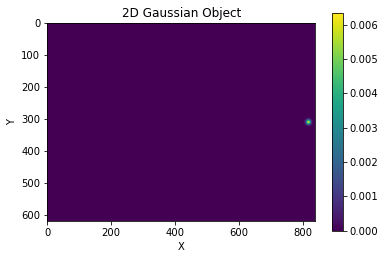

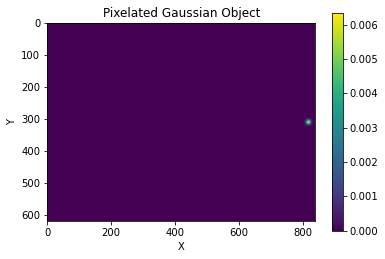

In [273]:
[x,y,coordinates] = gp.createMeshGrid(NX,NY)  
wavelengths = torch.arange(0,NL)
gauss_object = gp.GaussObject(0.,400.,1.,5.,5.,1.,1e0)
print(gauss_object)
gauss_object.plot(coordinates,NY,NX)
gauss_values = gauss_object.computeValues(coordinates, NY, NX)
plt.figure()
plt.imshow(gauss_values.detach().numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pixelated Gaussian Object')
plt.colorbar()
plt.show()

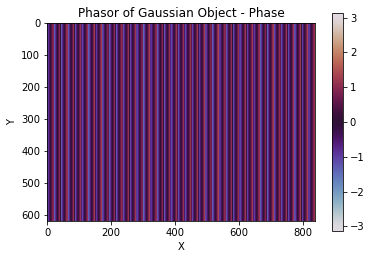

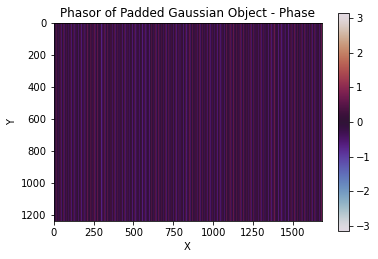

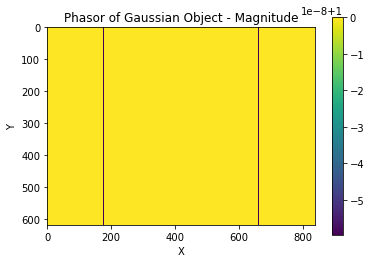

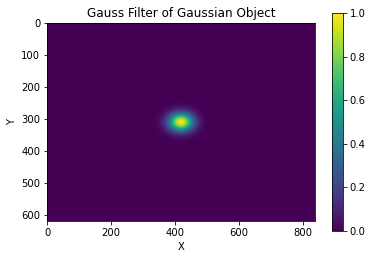

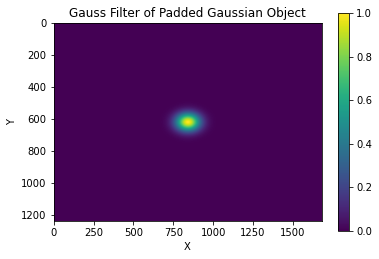

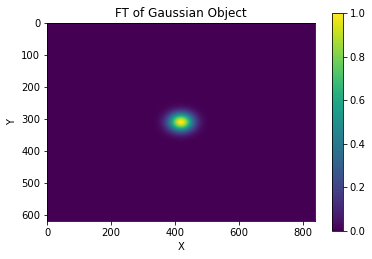

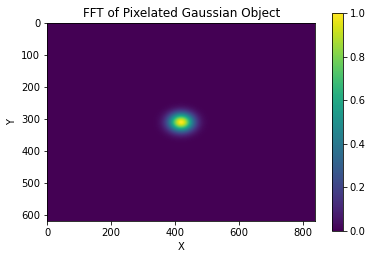

In [274]:
gauss_f_values = gp.createGaussFilter(gauss_object.covariancematrix, coordinates, NX, NY, gauss_object.amplitude)
gauss_phasor, gauss_phase_ramp = gp.createPhasor(x, y, gauss_object.mux, gauss_object.muy)

gauss_f_values_padded = gp.createGaussFilterPadded(gauss_object.covariancematrix, NX, NY, gauss_object.amplitude)
gauss_phasor_padded, gauss_phase_ramp_padded = gp.createPhasorPadded(NX, NY, gauss_object.mux, gauss_object.muy)

plt.figure()
plt.imshow(torch.angle(gauss_phasor).detach().numpy(), cmap='twilight')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phasor of Gaussian Object - Phase')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(torch.angle(gauss_phasor_padded).detach().numpy(), cmap='twilight')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phasor of Padded Gaussian Object - Phase')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(torch.abs(gauss_phasor).detach().numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phasor of Gaussian Object - Magnitude')
plt.colorbar()
plt.show()

scale = 1
plt.figure()
plt.imshow(np.abs(gauss_f_values.detach().numpy())*scale)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gauss Filter of Gaussian Object')
plt.colorbar()
plt.show()

scale = 1
plt.figure()
plt.imshow(np.abs(gauss_f_values_padded.detach().numpy())*scale)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gauss Filter of Padded Gaussian Object')
plt.colorbar()
plt.show()

gauss_obj_fft = gauss_f_values * gauss_phasor * scale
plt.figure()
plt.imshow(torch.abs(gauss_obj_fft.detach()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('FT of Gaussian Object')
plt.colorbar()
plt.show()

# compute fft of the object.
gauss_values_fft = torch.fft.fftshift(torch.fft.fft2(gauss_values,dim=(0,1)))
gauss_values_fft = gauss_values_fft/torch.amax(torch.abs(gauss_values_fft))
plt.figure()
plt.imshow(torch.abs(gauss_values_fft.detach()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('FFT of Pixelated Gaussian Object')
plt.colorbar()
plt.show()


In [275]:
# Estimate the covariance matrix of the FFT of the pixelated Gaussian
gv_test = torch.abs(gauss_values_fft.detach())
ny_test, nx_test = gv_test.shape
gauss_values_test = gv_test.detach().numpy()
center_y, center_x = ny_test // 2, nx_test // 2

xs = np.arange(nx_test)
ys = np.arange(ny_test)
X, Y = np.meshgrid(xs, ys)

mean_x = np.sum(X * gauss_values_test) / np.sum(gauss_values_test)
mean_y = np.sum(Y * gauss_values_test) / np.sum(gauss_values_test)

sigma_x = np.sqrt(np.sum((X - mean_x)**2 * gauss_values_test) / np.sum(gauss_values_test))
sigma_y = np.sqrt(np.sum((Y - mean_y)**2 * gauss_values_test) / np.sum(gauss_values_test))

cov_matrix = np.array([[sigma_x**2, 0], [0, sigma_y**2]])
print("Estimated Covariance Matrix:")
print(cov_matrix)

Estimated Covariance Matrix:
[[723.12004951   0.        ]
 [  0.         390.77928298]]


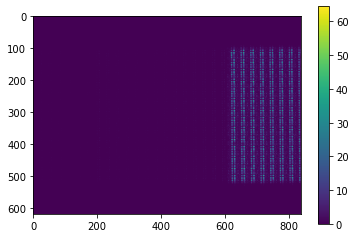

In [276]:
# forward model for each gauss object
gauss_object_measurement = gp.forwardSingleGauss(gauss_object, NX, NY, wavelengths, h, m)
plt.figure()
plt.imshow(gauss_object_measurement.detach().numpy())
plt.colorbar()
plt.show() 

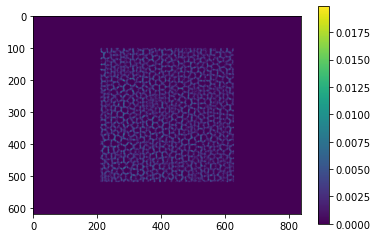

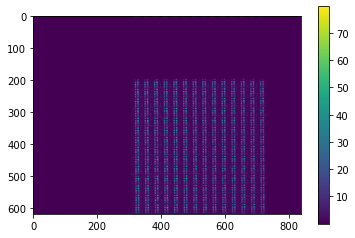

In [222]:
# try learning for a single gaussian object parameters 
# visualize the measurement in pixels space 
measurement_np = measurement.detach().cpu().numpy()
plt.figure()
plt.imshow(measurement_np)
plt.colorbar()
plt.show() 

gauss_object_measurement_np = gauss_object_measurement.detach().cpu().numpy()
plt.figure()
plt.imshow(gauss_object_measurement_np)
plt.colorbar()
plt.show() 

# learning

In [249]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

random_gaussian_object: gaussObject(mu_x = 10.0, mu_y = 100.0, mu_l = 1.0), cov = tensor([[1., 0.],
        [0., 1.]], requires_grad=True)


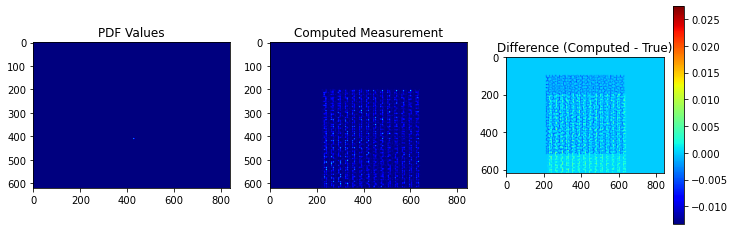

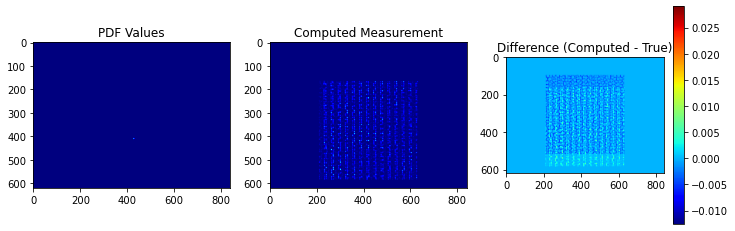

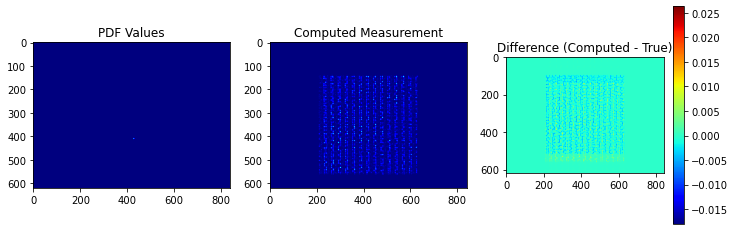

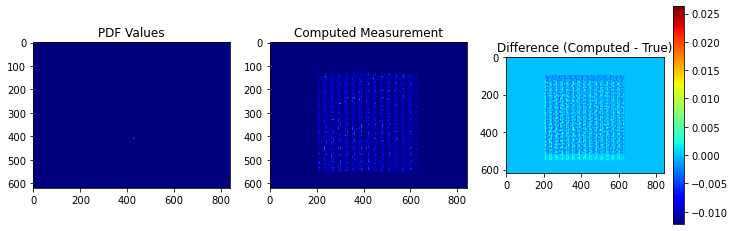

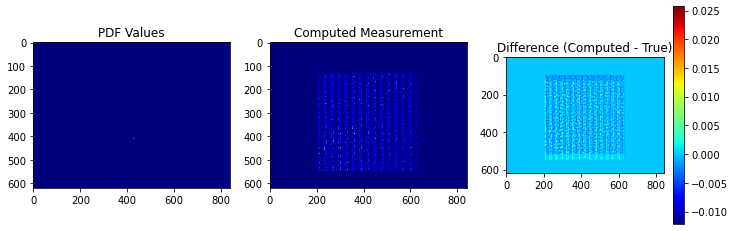

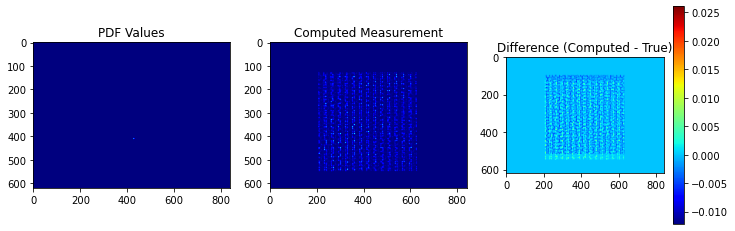

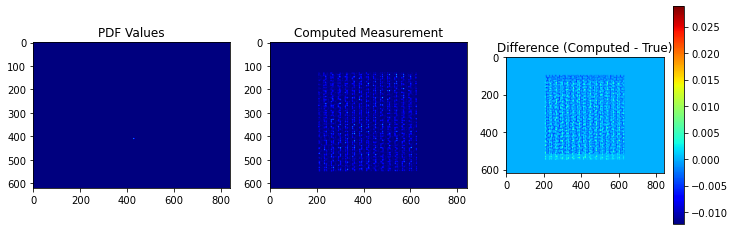

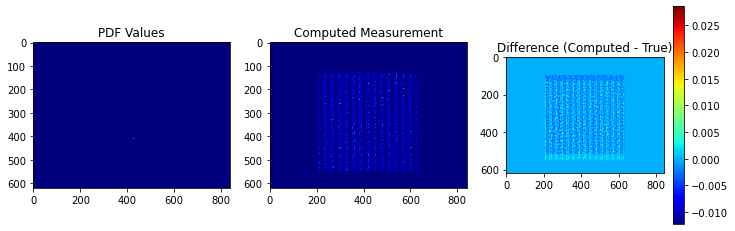

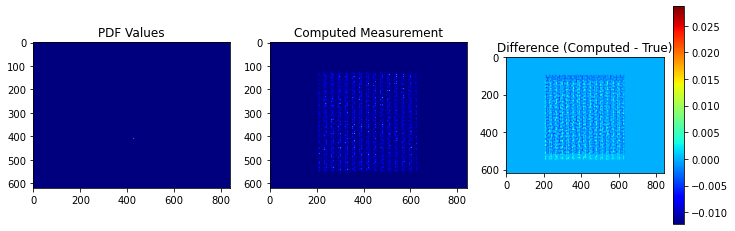

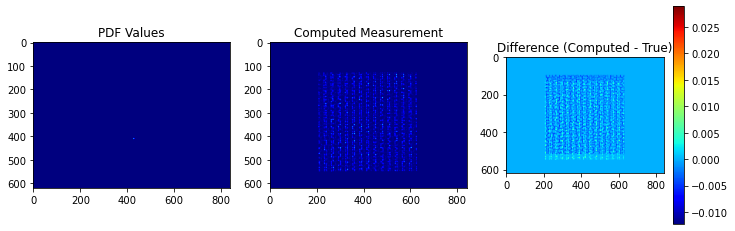

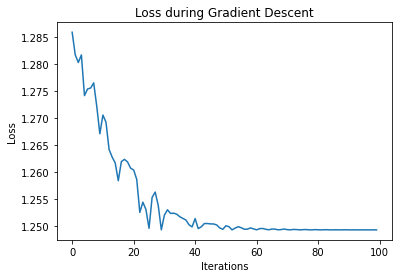

In [258]:
# Define a Gaussian object with randomly initialized values
random_gaussian_object = gp.GaussObject(
    muy=100.,  
    mux=10., 
    mul=1.,               
    sigy=1.0,  # Randomly initialized float
    sigx=1.0,  # Randomly initialized float
    sigl=1.0,  # Randomly initialized float
    amp=1.0,    # Randomly initialized float
    learningrate=0.01
)

print("random_gaussian_object:", random_gaussian_object)

# Set number of iterations and initialize the loss tracker
iterations = 100
loss_GD = []

# Optimization loop
for i in range(iterations):
    # Compute forward model using the current Gaussian parameters
    computed_measurement = gp.forwardSingleGauss(
        random_gaussian_object, coordinates, NX, NY, wavelengths, hf, x, y, m
    )
    
    # Normalize the computed measurement
    computed_measurement = computed_measurement / torch.norm(computed_measurement)
    
    # Compute PDF values based on the Gaussian parameters
    computed_values = random_gaussian_object.computeValues(coordinates, NY, NX)
    
    computed_values_np = computed_values.detach().cpu().numpy()
    computed_measurement_np = computed_measurement.detach().cpu().numpy()
#     print(computed_values_np)
    
    # Plot the results every 10 iterations (optional)
    if i % 10 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(computed_values.detach().cpu().numpy(), cmap='jet')
        plt.title("PDF Values")

        plt.subplot(1, 3, 2)
        plt.imshow(computed_measurement.detach().cpu().numpy(), cmap='jet')
        plt.title("Computed Measurement")

        plt.subplot(1, 3, 3)
        plt.imshow((computed_measurement - measurement).detach().cpu().numpy(), cmap='jet')
        plt.title("Difference (Computed - True)")
        plt.colorbar()
        
        plt.show()
    
    # Compute the loss (difference between computed measurement and true measurement)
    loss = torch.norm(computed_measurement - measurement)
    loss_GD.append(loss.item())
    
    # Perform a gradient step to update Gaussian parameters
    loss.backward()
    random_gaussian_object.gradStep()
    
    # Zero the gradients after the update
    random_gaussian_object.zeroGrad()

# Plot the loss over iterations
plt.figure()
plt.plot(loss_GD)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during Gradient Descent')
plt.show()


# Other stuff; not using right now

In [48]:
lr = [1e-2, 1e-2, 1e-2, 1e1, 1e-2, 1e-2] # mux, muy, mul, cov, sigl, amp
# how to set the learning rate? 
iterations = 5
loss_GD = []

# normalize the measurement
for k2 in range(iterations):
    # compute forward model
    padded_psf_zeros = torch.zeros_like(padded_psf)
    print(padded_psf_zeros.shape)
    individual_measurements = padded_psf_zeros + gp.forwardSingleGauss(gauss_object, coordinates, NX, NY, wavelengths, fft_psf, x,y, filter_array_normalized_tensor)  # compute individual measurements
    computed_values = gauss_object.computeValues(coordinates, NY, NX)
    individual_measurements = individual_measurements/torch.norm(individual_measurements)
    
    # plot the beads
    plt.figure()
    plt.subplot(1,4,1)
    plt.imshow(computed_values.detach().numpy()) ## pdf values
    plt.subplot(1,4,2)
    plt.imshow(individual_measurements.detach().numpy()) ## individual measurements
    plt.subplot(1,4,3)
    plt.imshow((individual_measurements-measurement).detach().numpy()) ## difference between reconstructed measurements and true measurement
    plt.show()
    
    # compute loss
    loss = torch.norm(individual_measurements - measurement)
    loss_GD.append(loss.item())
    loss.backward()

    # print gradients
    print(gauss_object.covariancematrix.grad.data)
    print(gauss_object.mux.grad.data)
    # update gaussian parameters
    gauss_object.gradStep(lr)
    gauss_object.zeroGrad()

plt.figure()
plt.plot(loss_GD)       
    

torch.Size([1680, 1680])


RuntimeError: The size of tensor a (1680) must match the size of tensor b (840) at non-singleton dimension 1

In [ ]:
## visualize computational graph

import torch
from torchviz import make_dot

# Define a simple neural network model
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = torch.nn.Linear(2, 2)  # First fully connected layer with 2 inputs and 2 outputs
        self.fc2 = torch.nn.Linear(2, 1)  # Second fully connected layer with 2 inputs and 1 output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the output of the first layer
        x = self.fc2(x)  # Pass the output through the second layer
        return x

# Initialize the model
model = SimpleModel()

# Create a random input tensor
input_tensor = torch.randn(1, 2)  # Batch size 1, 2 features

# Forward pass to generate the output tensor
output_tensor = model(input_tensor)

# Generate the computation graph visualization
dot = make_dot(output_tensor, params=dict(model.named_parameters()))
dot.view()


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
import graphviz

# Check if the 'dot' executable is found
graphviz.backend.DOT_PATH

AttributeError: module 'graphviz.backend' has no attribute 'DOT_PATH'